In [8]:
# When on Aura, it is important to first set CUDA_VISIBLE_DEVICES environment variable directly from notebook
# For available GPUs, see https://www.fi.muni.cz/tech/unix/aura.html.cs
from __future__ import annotations

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-4f7fbfb7-a8a2-553d-875a-d9d56baf97a"
os.environ["TOKENIZERS_PARALLELISM"] = "FALSE"

from sec_certs.utils.nlp import prec_recall_metric
from pathlib import Path
from sec_certs.model import ReferenceAnnotatorTrainer, ReferenceSegmentExtractor
from sec_certs.dataset import CCDataset
from sklearn.metrics import ConfusionMatrixDisplay

REPO_ROOT = Path("./../../../").resolve()
print(f"Resolved repo directory as: {REPO_ROOT}")

Resolved repo directory as: /var/tmp/xjanovsk/certs/sec-certs


In [5]:
# End-to-end example of reference annotation
dset: CCDataset = CCDataset.from_json(REPO_ROOT / "my_datasets/cc/cc_dataset.json")
dset.annotate_references(mode="training")

print(f"The dataset now contains {len([x for x in dset if x.heuristics.annotated_references])} certificates with annotated references.")

Recovering reference segments for reports: 100%|██████████| 82/82 [00:04<00:00, 20.45it/s]
config.json not found in HuggingFace Hub.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 560
  Num epochs = 1
  Total optimization steps = 35
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/35 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****


Internal evaluation (of model working on individual segments)
{'precision': 0.5384615384615384, 'recall': 0.5384615384615384}
Actual evaluation after ensemble soft voting
{'precision': 0.5714285714285714, 'recall': 0.5714285714285714}
The dataset now contains 43 certificates with annotated references.


In [6]:
# More dissected example with reference annotations
df = ReferenceSegmentExtractor().prepare_df_from_cc_certs(list(dset.certs.values()))
trainer = ReferenceAnnotatorTrainer.from_df(df, prec_recall_metric, method="transformer", mode="training")
trainer.train()
trainer.evaluate()

annotator = trainer.clf
df_predicted = annotator.predict_df(df)

Recovering reference segments for reports: 100%|██████████| 82/82 [00:03<00:00, 27.26it/s]
config.json not found in HuggingFace Hub.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 560
  Num epochs = 1
  Total optimization steps = 35
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/35 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****


Internal evaluation (of model working on individual segments)
{'precision': 0.5384615384615384, 'recall': 0.5384615384615384}
Actual evaluation after ensemble soft voting
{'precision': 0.5714285714285714, 'recall': 0.5714285714285714}


In [9]:
df_predicted.head()

,dgst,referenced_cert_id,label,split,segments,lang,y_proba,y_pred,correct
0,0041baf85c9ca3ec,BSI-DSZ-CC-0329-2006,NaN,valid,[[9] Certification Report BSI-DSZ-CC-0329-2006...,"[en, en]","[0.22958617238809345, 0.22039005448671678, 0.5...",COMPONENT_USED,NaN
1,0167c92c0d8c8b47,BSI-DSZ-CC-0844-2014,NaN,train,[As the evaluation work performed for this cer...,"[en, en, en]","[0.2379531649933594, 0.2068740269318838, 0.555...",COMPONENT_USED,NaN
2,09b17cb9b3c8b1bb,BSI-DSZ-CC-0917-2014,NaN,train,"[[PP0035], le 3 février\n2014 sous la référenc...","[fr, fr]","[0.2828401820477907, 0.25239069649528456, 0.46...",COMPONENT_USED,NaN
3,0ac0120f667a8dcf,BSI-DSZ-CC-0349-2006,NaN,train,[[CR]\nCertification Reports of underlying har...,[en],"[0.2314090673514774, 0.23112778759264926, 0.53...",COMPONENT_USED,NaN
4,0bf7a19b22163465,ANSSI-CC-2015/36,NaN,train,[[CER-\n2015/36]\nRapport de certification ANS...,[fr],"[0.3772119113773801, 0.2939748191664766, 0.328...",EVALUATION_REUSED,NaN


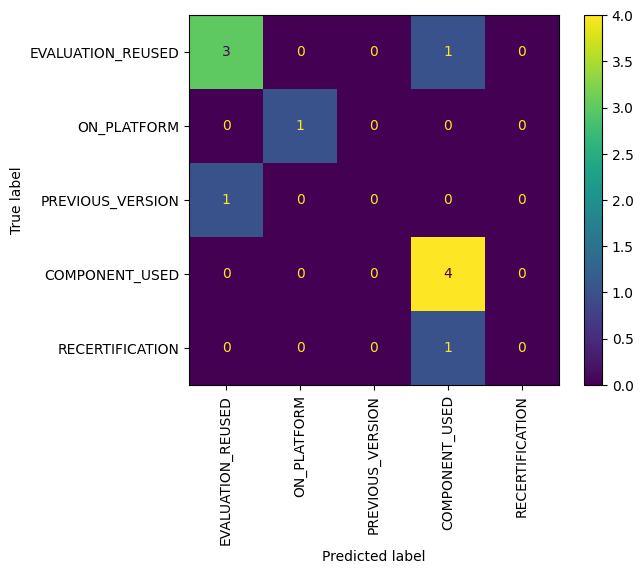

In [15]:
df_labeled = df_predicted.loc[df_predicted.label.notnull()]
ConfusionMatrixDisplay.from_predictions(df_labeled.label, df_labeled.y_pred, labels=df_labeled.label.unique(), display_labels=df_labeled.label.unique(), xticks_rotation=90)